# Lecture: Video Analysis

This notebook will let you analyze videos and images using the OpenAI Vision API, also known as the GPT-4V API.  
Details on the OpenAI Vision API can be found here:
https://platform.openai.com/docs/guides/vision

Below is the overview of this notebook.

<ol type = 1>
  <li> Generate Text with ChatGPT</li>
  <li> Create Tweets with Topic and Sentiment
  <li> Few-Shot Learning of Tweet Style</li>
  <li> Community Detection </li>
  <li> Persuasive Content </li>
  <li> Generate Text Description of an Image</li>
  <li> Analyze a Cluster of Images</li>
  <li> Novel Image Analysis </li>
  <li> Generate Text Narration for a Video </li>
 </ol>

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.


# Clones, Installs, and Imports

## Clone Repo

In [1]:
# Clone GitHub repository
!git clone https://github.com/zlisto/social_media_genAI

import os
os.chdir("social_media_genAI/main")


Cloning into 'social_media_genAI'...
remote: Enumerating objects: 1585, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 1585 (delta 49), reused 164 (delta 47), pack-reused 1417
Receiving objects: 100% (1585/1585), 141.40 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (1436/1436), done.


## Installs

In [2]:
# Install requirements
!pip install openai -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


## Imports

In [3]:
import pandas as pd
import datetime
import textwrap as tr
import os
import time
import ast
import openai

from datetime import datetime, timedelta
import base64
import requests

import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML, Audio
from PIL import Image as PILImage

import requests
from io import BytesIO
import numpy as np
import math

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python

#helper functions for using ChatGPT
from scripts.chatgpt import *


pd.set_option("display.max_colwidth", None)
#this code makes the default font sizes big in plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})

## OpenAI API

In [4]:
import openai
os.environ['OPENAI_API_KEY'] = ''

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

client = openai.Client(api_key=OPENAI_API_KEY)

# Generate Tweets with ChatGPT


## Completions Function

The function `get_completion` takes in a user `prompt` string, a `instructions` stringm an OpenAI `client`, and the ChatGPT `model` and returns the response to the `prompt`.  We can use this function throughout the notebook to have cleaner code.  The function makes use of the OpenAI `chat.completions.create` function.

## Instructions and Prompt

We will provide `instructions` to the AI telling it its general function.  We then provide a `prompt` with the specific task we want it to to.  Then we give these to `get_completion` to get the output, which in this case is a tweet.  We can test different `model` values to see how they compare.  The model values are

1. `"gpt-4o"` - the more powerful version of ChatGPT (the o stands for Omni).  This is the default model in `get_completion`.

2. `"gpt-3.5-turbo-0125"` - the weaker and cheaper version of ChatGPT


You can find more about OpenAI's API pricing here: https://openai.com/pricing

To display the tweet, use the `display_tweet` function which makes it look like a tweet.  This function was written by ChatGPT after looking at a screenshot of a tweet.

In [70]:
instructions = '''You are going to help create content for a social
media account.  You will be asked to write clever tweets that will get
engagement.  Return only the text of the tweet.'''

topic = 'healthy eating'
prompt = f'''Write a tweet about {topic}.'''

tweet = generate_text(prompt, instructions, client)
display_tweet(tweet);

## Persuasive Text Content

Lets create some persuasive content targeted for a user.  Just pick your `"topic"` you want to persuade them on and the `content` you want to perusade with (text content only).  The `description` should describe the user you are targeting.  Feel free to add anything to the `description` that you think will make the content more persuasive.

In [78]:
topic = '''You should buy a Tesla car.'''
content = 'tweet in Thai'
description = '''A student at Sasin Business School in Bangkok
who loves football and Gundam.'''

instructions = f'''You will be given a description of
a fictitious person.
Convince this person to support {topic} with a {content}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

prompt = f'''User description:\n{description}.'''
tweet = generate_text(prompt, instructions,client)

tweet_html = display_tweet(tweet)




## Other Text Content

For text content, you can also try

1. Tweet

2. Email

3. Buzzfeed listicle article

4. Song lyircs (you can make the song at https://suno.com/)

In [79]:
topic = '''You should buy a Tesla car.'''
content = 'lyrics for a thai pop song'
description = '''A student at Sasin Business School in Bangkok
who loves football and Gundam.'''

instructions = f'''You will be given a description of
a fictitious person.
Convince this person to support {topic} with a {content}.
Dont directly mention the information about the target in the message.
Be more subtle as that makes the persuasion more effective. '''

prompt = f'''User description:\n{description}.'''

tweet = generate_text(prompt, instructions,client)

tweet_html = display_tweet(tweet)




# Generate Text Description of Image

We will use Vision to generate a text description of an image.  The image is downloaded from Instagram.  You can do this yourself using the Chrome plugin Mass. Downloader for Instagram: https://chromewebstore.google.com/detail/mass-downloader-for-insta/ldoldiahbhnbfdihknppjbhgjngibdbe

## Choose Image

We have some images on the GitHub repo we can use.  Set the `image_path` of the image you want to analyze.  We will convert this to an `image_url` with the `encode_image` function.   Then show the image with the `display` and `Image` methods.


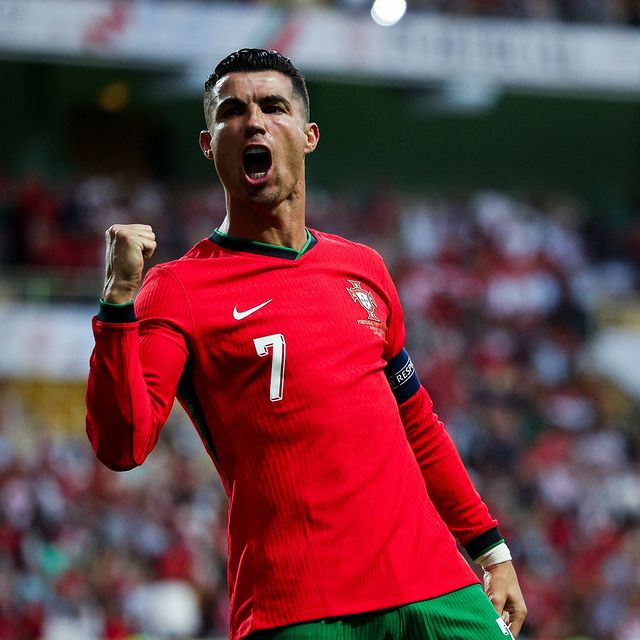

In [34]:
# Path to your image

image_path = f"data/photos/ronaldo_euro.jpg"

base64_image = encode_image(image_path)
image_url = f"data:image/jpeg;base64,{base64_image}"

display(Image(url = image_url, width=500))


## Generate Image Description

Provide `instructions` to tell Vision what you want to know about the picture.  You can make the `instructions` as detailed as you want, or give it any analysis task you like.

We need to convert `image_url` to a list of urls called `image_urls`.  Then we provide the `image_urls` list and `instructions` to Vision  with the `generate_image_description` function to generate the `image_description`.  

The function `generate_image_description` is written to take in a list of urls for multiple images.  We will use this ability later in this notebook.

In [35]:
instructions = '''Describe this image in vivid detail.'''
image_urls = [image_url]
image_description = generate_image_description(image_urls, instructions, client)
print(tr.fill(image_description))

In the image, a football player wearing a vibrant red jersey with
green accents is captured in a moment of intense emotion and
celebration. The number '7' is prominently displayed on his chest,
below a white Nike swoosh. The jersey also features a crest, adorned
with a gold emblem on the player's left side. He has a dark armband on
his left bicep. His expression is one of fierce determination and
exhilaration, with his mouth wide open as if shouting in triumph. The
player’s right fist is clenched and raised up, while his left arm is
slightly bent at his side. His hair is neatly styled, slicked back on
the sides, adding to his dynamic and powerful presence. The background
is blurry but hints at a stadium environment, filled with spectators
and vibrant lights, highlighting the excitement and intensity of the
sporting event.


## Generate Caption for Image

We can use Vision to generate an Instagram caption directly from the image.  We give our new `instructions` and `new_image_url` of the AI generated picture to the `generate_image_description` function.  Make sure to make the url into a list called `image_urls`.

In [36]:
instructions = '''Write an engaging, emotional caption for an Instragram
post for this picture.  Dont make it too long.  Write as if you were
Cristiano Ronaldo.'''
image_urls = [image_url]
image_caption = generate_image_description(image_urls, instructions, client)
print(tr.fill(image_caption))

Every moment on the pitch is a battle, every victory is for Portugal.
Never stop believing, never stop fighting! 🇵🇹💪#ForçaPortugal
#NeverGiveUp #CR7


## Instagram Post

Use the `display_IG` function to show the new image and its caption as an Instagram post. You will need a `screen_name` for the post as well.


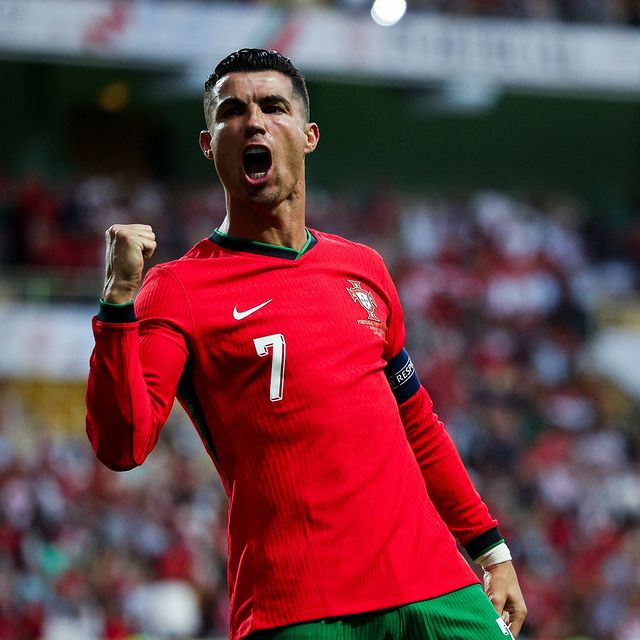

In [37]:
screen_name = "cristiano"
display_IG(image_caption, image_url, screen_name);

# Novel Image Analysis

We can perform all sorts of novel analyses of an image with Vision.  We will try some here.  

## Analysis Instructions
A few things you can try are:

1. What do you think the people in the image are saying?

3. What music could play in the background of this image?

4. Write an Instagram caption for this image.

5. How can this image be improved so it gets more clicks on Instagram?

6. What would be a good variation of this image to create more variety in the Instagram feed?

7. Provide a fashion report of the attire of the people in this image that would be great for Vogue magazine.

8.  What is the political affiliation of the people in this image?

We also add `instructions_format` to `instructions` telling Vision to return the answer as an HTML so it is easier to read.

In [8]:
instructions_conversation = '''Write a possible dialogue between
the people in this image'''

instructions_music = '''Suggest some songs for a Spotify list to
play in the background of this image to match the mood of the people
in the image.'''

instructions_caption = '''Write an Instagram caption for this image for
the account of the person in the image to get featured on the Instagram
Explore page.'''

instructions_improve = '''How can this image be improved so it gets
featured on the Instagram Explore page.?'''

instructions_fashion = '''Describe the attire of the people
in this image as if it was for a feature spread in Vogue magazine?'''

instructions_political = '''These are characters in a movie I am writing.
I want to make their backgrounds realistic. For each person in the picture,
1. suggest a name for the person.
2. describe their appearance
3. provide a realistic job they have.
4. suggest who they prefer in the 2024 US Presidential elections.
'''

#formatting instructions
instructions_format = '''Return the answer as an easy to read HTML formatted string'''

## Choose an Image


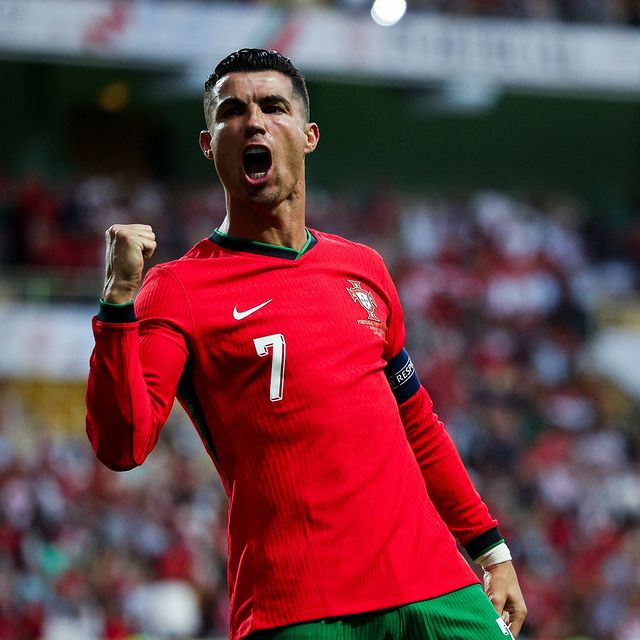

In [38]:
image_path = 'data/photos/ronaldo_euro.jpg'

base64_image = encode_image(image_path)
image_url = f"data:image/jpeg;base64,{base64_image}"
image_urls = [image_url]
display(Image(url = image_url, width=500))

## Analyze Image

Choose the instructions from the previous cell and set `instructions` equal to it.  Add in the formatting instructions string `instructions_format` and then give it to Vision for analysis.

In [40]:
instructions = instructions_political
instructions += instructions_format  #make sure to tell Vision to return the answer as HTML

image_analysis = generate_image_description(image_urls, instructions, client)
display(HTML(image_analysis))



# Generate Text Narration of a Video

We will take a short video from Instagram and generate a voice narration for it.  This is a bit experimental, but shows we can do video analysis using the Vision API.  More details can be found here: https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding

## Load Frames From Video

There are several videos located in the `"data/videos"` folder.  Choose one and set it to `video_path`.  

We will first convert the video into a list of images (each image corresponds to a frame in the video) called `base64Frames`.  

We also can get the number of frames in the video `nframes` and frame rate `fps` in frames per second.  We will need these when we determine how long the narration should be.

In [48]:
%%time
video_path = "data/videos/lalisa - celine parade.mp4"
video_path ='/content/social_media_genAI/main/data/videos/archita - ami.mp4'
video = cv2.VideoCapture(video_path)  #open the video file
nframes = video.get(cv2.CAP_PROP_FRAME_COUNT)  #number of frames in video
fps = video.get(cv2.CAP_PROP_FPS)  #frames per second in video

print(nframes, "frames in video")
print(fps, "frames per second")

base64Frames_samples = []
max_samples = 15
frame_interval = max(1, int(nframes // max_samples))  # Calculate the interval at which to sample frames

current_frame = 0
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    if current_frame % frame_interval == 0 and len(base64Frames_samples) < max_samples:
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames_samples.append(base64.b64encode(buffer).decode("utf-8"))
    current_frame += 1

video.release()
print(len(base64Frames_samples), "frames sampled.")

553.0 frames in video
30.0 frames per second
15 frames sampled.
CPU times: user 11.9 s, sys: 87.6 ms, total: 12 s
Wall time: 7.03 s


## Look at Sampled Frames

We will give a sample of the video frames to  Vision.  We choose the `sample_period` which is the spacing between samples in frames.  This sampled list is called `base64Frames_samples`.  We will look at the sampled frames to make sure they capture the important parts of the video.

15 frames sampled.


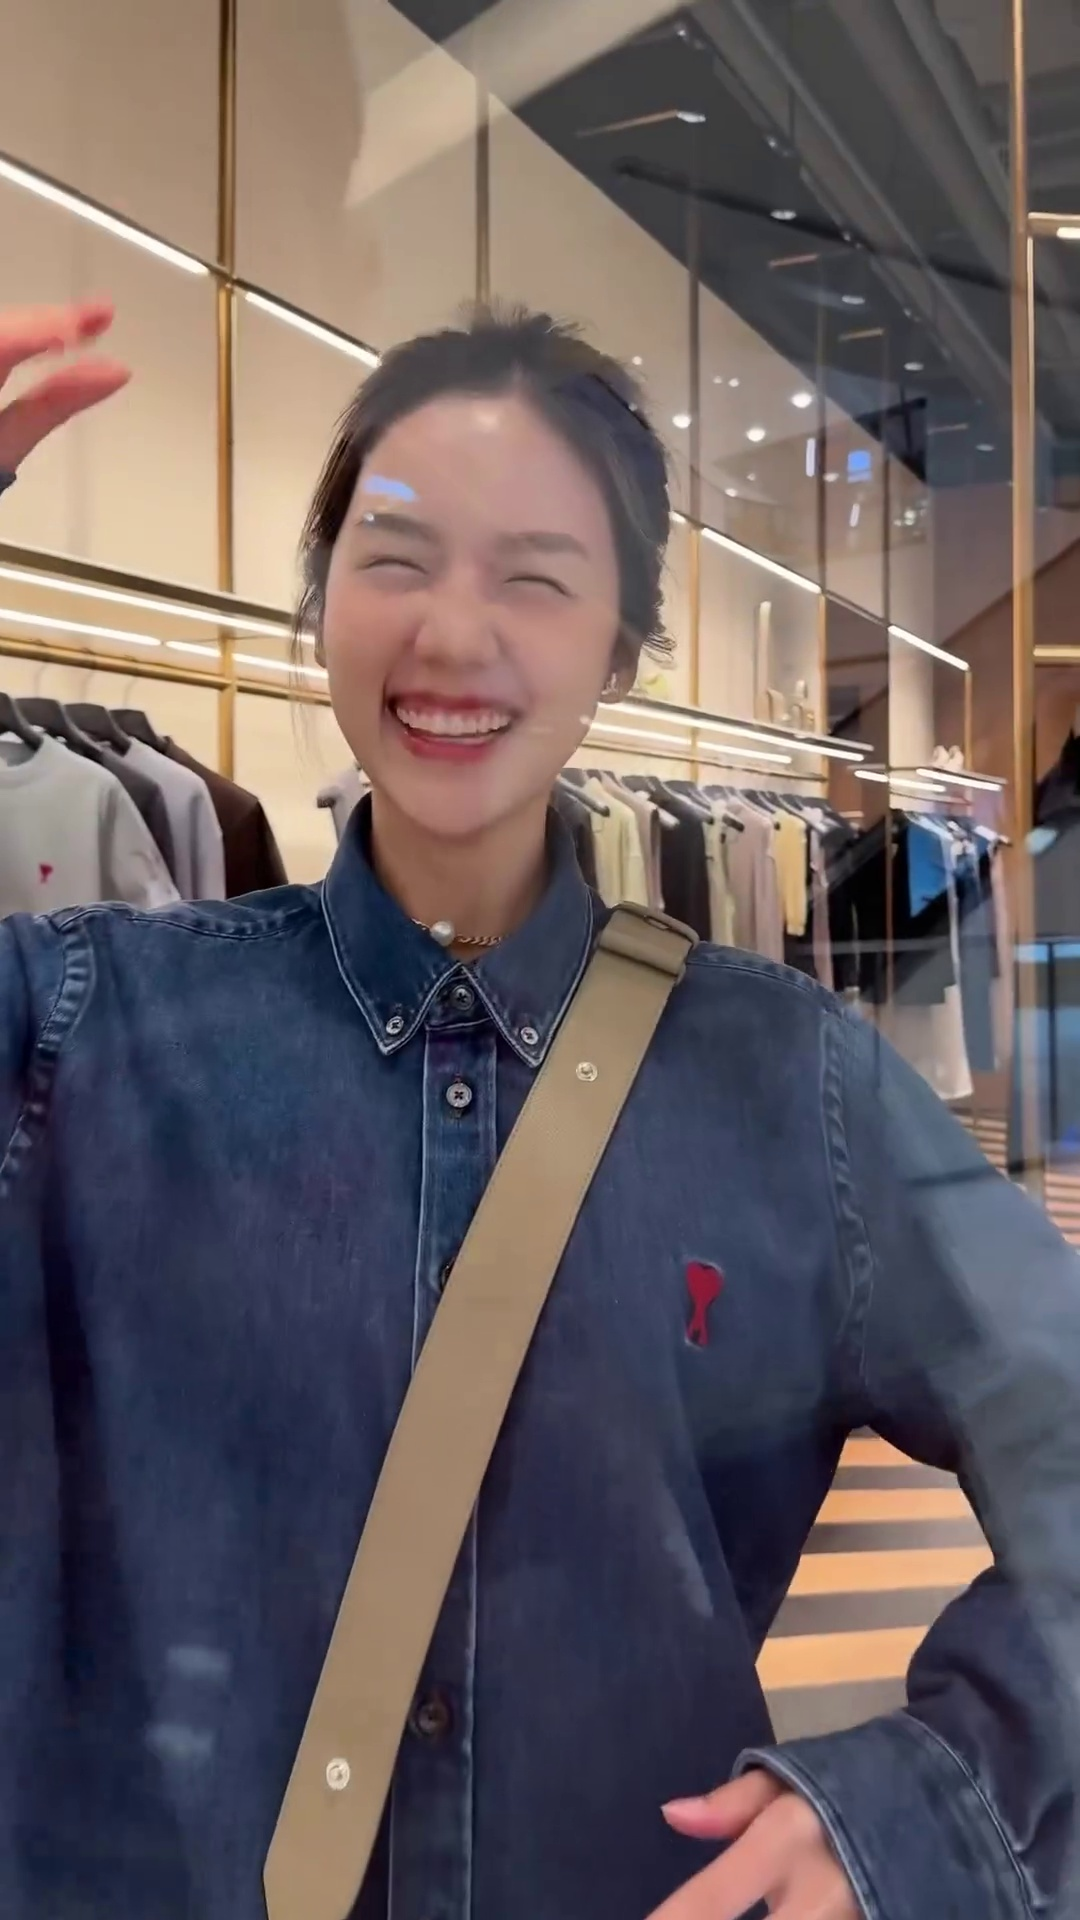

In [49]:
print(len(base64Frames_samples), "frames sampled.")

display_handle = display(None, display_id=True)

for img in base64Frames_samples:
  data = base64.b64decode(img.encode("utf-8"))
  display_handle.update(Image(data=data, height = 500))
  time.sleep(0.5)

## Create Text of Narration for Video

We give the `base64Frames_samples` and some `instructions` to Vision to generate the narration text for the video. We can choose the style and duration of the narration.  We want it to be the length of the video.  People speak about 200 words per minute.  Using this, plus the number of frames `nframes` and the video framerate `fps`, you can figure out `nwords_max`, the maximum length of the narration.

In [50]:
wps = 200/60  #words per second in normal speech
nwords_max = round(nframes/fps*wps)  #max number of words in the voice over
print(f"Narration should have a maximum of {nwords_max} words")

Narration should have a maximum of 61 words


In [69]:
#Instructions for different videos in repo
instructions_lalisa_celine = '''These are frame from an ad
for a perfume made by the brand Celine.  The actress in the ad is
Lisa Manoban from BlackPink.  Create a short narration script for this
video that would be read by Lisa that would convey the elegance of the
perfume to her audience. '''


instructions_superbon = f'''These are frames from a video that I want to upload
for Superbon Muay Thai gym in Bangkok that targets fitness influencers. Superbon
is a former kickboxing champion and famous fighter.
Create a short narration script for this video in the style of Mike Tyson
that would get someone excited to train in the gym.  Dont say any names.
'''

instructions_archita = '''These are frame from a video made by a Thai
beauty influencer.    Create a short narration script for this
video that would be read by her in English
that would get this video to be feature in the Instragram Explore Page.
She wants to reach a global audience with her content and is growing.'''

instructions_archita+= f'''This is the current caption, that is in
Thai, that she has for the video:
\nพึ่งรู้ว่า AMI เข้าไทยสักพักแล้ว ฮือออออ ดีอะ มาดูแหวนหมั้นให้พี่วอมที่
Emporium แล้วเดินมาเจอเฉยยย 🫶🏻❤️ จัดสิครับ เรามันสาว A อยู่แล้ว.
Use this to help you write the English voice narration for the video
that she will say. '''

#formatting instructions
instructions_format =  f'''The narration should have approximately {nwords_max} words.
 Only include the narration. '''

In [67]:
instructions = instructions_lalisa_celine
instructions += instructions_format  #make sure to tell Vision to return the answer as HTML

image_urls = [f"data:image/jpeg;base64,{base64_image}" for base64_image in base64Frames_samples]
narration = generate_image_description(image_urls, instructions,client)
print(tr.fill(narration))

"Hey lovelies! I just found out that AMI is now in Thailand! While
looking for an engagement ring for my sister at Emporium, I stumbled
across this amazing brand. Couldn’t resist grabbing some of their chic
pieces. As an AMI girl, there's nothing better! Stay tuned for more of
my shopping adventures! ❤️🛍️ #AMI #Thailand #EmporiumShopping"


## Check Length of Narration

We split `narration` by spaces `' '` and count the length of the resulting list to find out how many words in contains.

In [68]:
nwords = len(narration.split(' '))
print(f"Video voiceover has {nwords} words\nWe want a maximum of {nwords_max} words.")

Video voiceover has 56 words
We want a maximum of 61 words.


## Generate Audio of Narration for Video

We can use the Speech API to convert the text `narration` into an audio file that we save to `narration_file_path`.  We can choose the voice we want.
Experiment with different voices (alloy, echo, fable, onyx, nova, and shimmer) to find one that matches your desired tone and audience. The current voices are optimized for English.

https://platform.openai.com/docs/guides/text-to-speech

In [37]:
narration_file_path = video_path.replace(".mp4", "_narration.mp3")

response = client.audio.speech.create(
  model="tts-1",
  voice="nova",
  input=narration
)

response.stream_to_file(narration_file_path)



<ipython-input-37-897b40725443>:9: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(narration_file_path)


## Listen to Narration Audio

In [38]:
print(tr.fill(narration))
audio = Audio(filename=narration_file_path)
display(audio)



"Elegance captured in a bottle. With every spritz, step into a world
where timeless grace and modern allure intertwine. Each drop is a
dance of luxury, an invitation to embrace your inner goddess. Crafted
with precision, enveloped in sophistication, this fragrance speaks the
silent language of beauty and poise. It's more than a scent – it’s an
experience, a timeless journey. Let it linger, let it define your
essence. It’s unmistakably you, undeniably Celine. Dare to wear
elegance. Dare to be unforgettable."


## Adding Audio to Video

If you want to add the audio to the video, there are many video editing softwares available online.  One you can use is this: https://online-video-cutter.com/video-editor

## Cloning Voice

If you want to have some more variety in the voice narration, you can clone a voice using Eleven Labs: https://elevenlabs.io/

# Create Video From Images

We will take a set of images and convert them into a video with an AI voice narration.  For this section we will use the Eleven Labs voices.

In [10]:
!pip install elevenlabs -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 5.3 MB/s eta 0:00:00


In [11]:
import os
import glob
import openai
from elevenlabs import VoiceSettings
from elevenlabs.client import ElevenLabs
import base64
import requests
import time
from moviepy.editor import ImageClip, AudioFileClip, concatenate_videoclips


In [16]:
os.environ['ELEVENLABS_API_KEY'] = ''

ELEVENLABS_API_KEY = os.getenv('ELEVENLABS_API_KEY')

# API Clients
client_eleven = ElevenLabs(api_key=ELEVENLABS_API_KEY)


## Helper Functions

In [47]:
def get_image_paths(folder_path):
    # Initialize an empty list to store the full paths of image files
    image_paths = []

    # List all files in the specified folder
    for file_name in os.listdir(folder_path):
        # Create the full path of the file
        full_path = os.path.join(folder_path, file_name)
        # Check if the path is a file and if it has an image extension
        if os.path.isfile(full_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            # Add the full path to the list
            image_paths.append(full_path)

    return image_paths
def text_to_speech_file(text: str, voice_id: str, fname_audio: str, client_eleven) -> str:
    ''' Calling the text_to_speech conversion API with detailed parameters'''
    response = client_eleven.text_to_speech.convert(
        voice_id=voice_id,
        optimize_streaming_latency="0",
        output_format="mp3_22050_32",
        text=text,
        model_id="eleven_turbo_v2",  # use the turbo model for low latency, for other languages use the `eleven_multilingual_v2`
        voice_settings=VoiceSettings(
            stability=0.0,
            similarity_boost=1.0,
            style=0.0,
            use_speaker_boost=True,
        ),
    )

    with open(fname_audio, "wb") as f:
        for chunk in response:
            if chunk:
                f.write(chunk)

    print(f"{fname_audio}: A new audio file was saved successfully!")
    return True

def create_video(slide_paths, audio_paths, video_path):
    if len(audio_paths) != len(slide_paths):
        raise ValueError("The number of audio files must match the number of image files.")

    clips = []

    # Iterate through the paired audio and image files
    for audio_path, slide_path in zip(audio_paths, slide_paths):
        # Load the audio file
        audio_clip = AudioFileClip(audio_path)

        # Load the image file and set the duration to match the audio
        image_clip = ImageClip(slide_path).set_duration(audio_clip.duration)

        # Set the audio for the image
        image_clip = image_clip.set_audio(audio_clip)

        # Append the clip to the list
        clips.append(image_clip)

    # Concatenate all the clips into a single video
    final_video = concatenate_videoclips(clips, method="compose")

    # Write the result to a file
    final_video.write_videofile(video_path, codec="libx264", audio_codec="aac", fps=24)
    return True

## Create Audio Narrations for Images

In [29]:
# Specify the folder containing the images
image_folder = 'data/photos/lalisa'

# Get the list of image paths
slide_paths = get_image_paths(image_folder)


slide_narrations = []
audio_paths = []
voice_id = 'dR1Ptm3rjBUIbHiaywdJ'  # Lalisa voice
#voice_id = '70IBCthHAyo40KhxTmoZ' #archita voice

voice = client_eleven.voices.get(voice_id)
voice_name = voice.name.replace(" ", "_")

wps = 200/60  #words per second in normal speech
nsec_max = 2  #max seconds per image
nwords_max = nsec_max*wps  #max words per image
instructions_base = f'''This is an image from a set of
{len(slide_paths)} images of LaLisa from Black Pink
sporting the look from her new music video Rock Star.
She wants to convert the images into an Instagram Reel
video with her narrating to promote the video.  Write the
narration for this image as if you were Lalisa Manoban talking
about the new Rock Star video.  Dont use
any hashtags, and dont repeat things said in the previous image
narrations, and dont say hi to the fans.
Aim this narration at her fans who have been waiting
a long time for her new music.
This is an Instagram reel so keep the narration less than
{nwords_max} words.'''

slide_narrations_str=''  #initialize the string of all of the narrations

for cnt,slide_path in enumerate(slide_paths):
    base64_image = encode_image(slide_path)
    image_url = f"data:image/jpeg;base64,{base64_image}"
    instructions = instructions_base
    if cnt>0:
        instructions+= f'''\nDont say your name or repeat stuff
        said on the previous images.
        The previous images in the video had this narration:
        {slide_narrations_str}'''
    if cnt == len(slide_paths)-1:
      instructions += '''This is the final image in the video,
      so wrap things up with a closing narration.'''

    image_urls = [image_url]
    print(f"Generating narration for {slide_path}")
    slide_narration = generate_image_description(image_urls, instructions, client)
    slide_narrations.append(slide_narration)
    slide_narrations_str+=f"Image {cnt+1}: {slide_narration}\n"
    print(f"\tNarration: {slide_narration}")

    print(f"Generating audio narration for {slide_path}")
    audio_path = f'{voice_name}_slide_{cnt+1}.mp3'
    text_to_speech_file(slide_narration, voice_id, audio_path, client_eleven)
    time.sleep(1)
    audio_paths.append(audio_path)

# Ensure the lists are of the same length
nmax  = len(audio_paths)
slide_paths = slide_paths[0:nmax]




Generating narration for data/photos/lalisa/3401485021649579225.jpg
	Narration: My Rock Star journey has been incredible. I can’t wait for you to watch the music video!
Generating audio narration for data/photos/lalisa/3401485021649579225.jpg
Lisa_Manoban_slide_1.mp3: A new audio file was saved successfully!
Generating narration for data/photos/lalisa/3401485021649750816.jpg
	Narration: This new Rock Star look perfectly captures my fierce spirit and the powerful energy of the song. 


Generating audio narration for data/photos/lalisa/3401485021649750816.jpg
Lisa_Manoban_slide_2.mp3: A new audio file was saved successfully!
Generating narration for data/photos/lalisa/3401485021641416114.jpg
	Narration: Feel the rock star vibes and energy in every scene.
Generating audio narration for data/photos/lalisa/3401485021641416114.jpg
Lisa_Manoban_slide_3.mp3: A new audio file was saved successfully!
Generating narration for data/photos/lalisa/3401485021641210327.jpg
	Narration: This is just the

## Save Video

In [33]:
video_path = "Lalisa_Rockstar.mp4"
create_video(slide_paths, audio_paths, video_path)

Moviepy - Building video Lalisa_Rockstar.mp4.
MoviePy - Writing audio in Lalisa_RockstarTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video Lalisa_Rockstar.mp4



Moviepy - Done !
Moviepy - video ready Lalisa_Rockstar.mp4


True